# Flow-Aware Hillshade

This tutorial shows how to create an implementation of Joe Macgregor's 'flow-aware hillshade' (MacGregor _et al._ 2024) to interpret basal topography, using ITS_LIVE velocity data an the `pdemtools` hillshade function.

> MacGregor, J. A., Colgan, W. T., Paxman, G. J. G., Tinto, K. J., Csathó, B., Darbyshire, F. A., et al. (2024). Geologic provinces beneath the Greenland Ice Sheet constrained by geophysical data synthesis. Geophysical Research Letters, 51, e2023GL107357. https://doi.org/10.1029/2023GL107357

In [1]:

import pdemtools as pdt
import rioxarray as rxr
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from rasterio.enums import Resampling


In [2]:

# Jakobshavn Isbræ bounds (xmin, ymin, xmax, ymax in EPSG:3413)
bounds = (-176000, -2287000, -162000, -2273000)


## Download ArcticDEM

First, we can download the 32 m ArcticDem mosaic using `pdemtools`.

In [3]:

%%time
dem = pdt.load.mosaic(
    dataset='arcticdem',  # must be `arcticdem` or `rema`
    resolution=32,        # must be 2, 10, or 32
    bounds=bounds,        # (xmin, ymin, xmax, ymax) or shapely geometry
    version='v4.1',       # optional: desired version (defaults to most recent)
)


CPU times: user 163 ms, sys: 40.9 ms, total: 204 ms
Wall time: 9.86 s


In [4]:

hillshade = dem.pdt.terrain('hillshade', hillshade_z_factor=2, hillshade_multidirectional=True)


Text(0.5, 1.0, '')

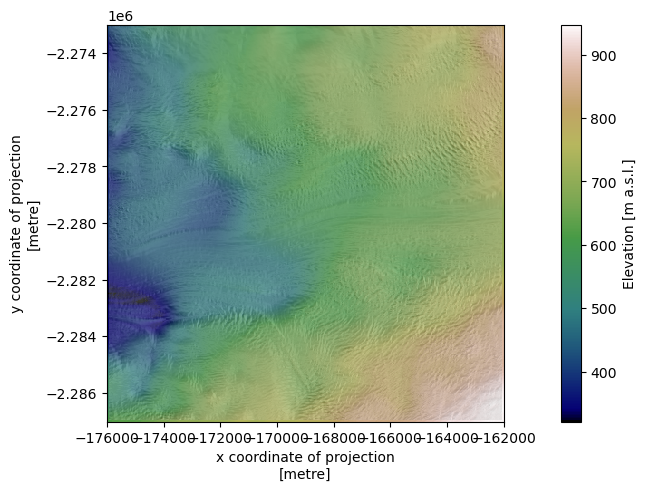

In [5]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

dem.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Elevation [m a.s.l.]'})
hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(None)


## Download ITS_LIVE mosaic

We can download the the ITS_LIVE multiyear velocity mosaic from the AWS-stored cloud-optimised geotiffs:

In [6]:

vx_fpath = "https://its-live-data.s3-us-west-2.amazonaws.com/velocity_mosaic/v2/static/cog/ITS_LIVE_velocity_120m_RGI05A_0000_v02_vx.tif"
vy_fpath = "https://its-live-data.s3-us-west-2.amazonaws.com/velocity_mosaic/v2/static/cog/ITS_LIVE_velocity_120m_RGI05A_0000_v02_vy.tif"


We can download and resample these to match the DEM using `rioxarray`.

In [7]:

vx = rxr.open_rasterio(vx_fpath).rio.clip_box(*bounds)
vy = rxr.open_rasterio(vy_fpath).rio.clip_box(*bounds)

vx = vx.rio.reproject_match(dem, resampling=Resampling.cubic)
vy = vy.rio.reproject_match(dem, resampling=Resampling.cubic)

vv = np.sqrt(vx ** 2 + vy ** 2)


Text(0.5, 1.0, '')

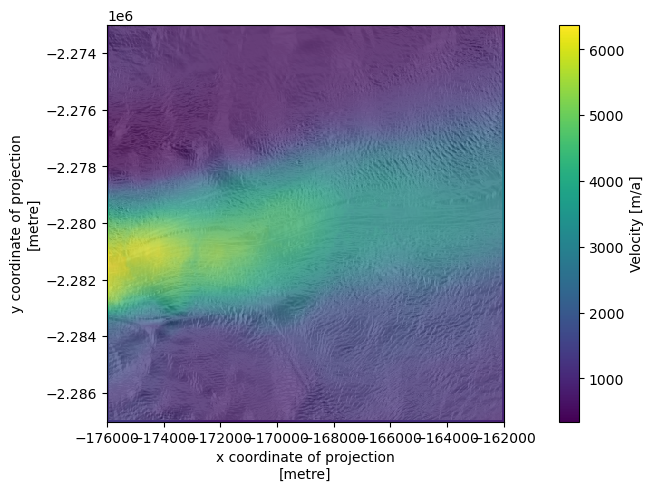

In [8]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

vv.plot(cmap='viridis', ax=ax, cbar_kwargs={'label': 'Velocity [m/a]'})
hillshade.plot(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title(None)


## Calculate flow aware hillshade

We now have all of our data to calculate the flow-aware hillshade. MacGregor _et al._ (2024) specify that the illumination azimuth must be 90˚ anticlockwise to the filtered flow direction, so that is what we calculate in this function (note also the we output the degrees in degrees-clockwise-from-north, to match the expected input of the `pdemtools` hillshade function).

In [9]:

def get_flow_direction(vx, vy, offset=-90):
    
    direction_rad = np.arctan2(vy, vx) 
    direction_deg = np.rad2deg(direction_rad) - 90 + 360

    direction_deg += -offset
    
    return 360 - (direction_deg % 360)
    
azimuth = get_flow_direction(vx, vy)


This can get confusing, so it's always best to check by plotting our calculated azimuth. We can see that where flow is due west (270˚), our azmuth is 180˚, so this works!

Text(0.5, 1.0, '')

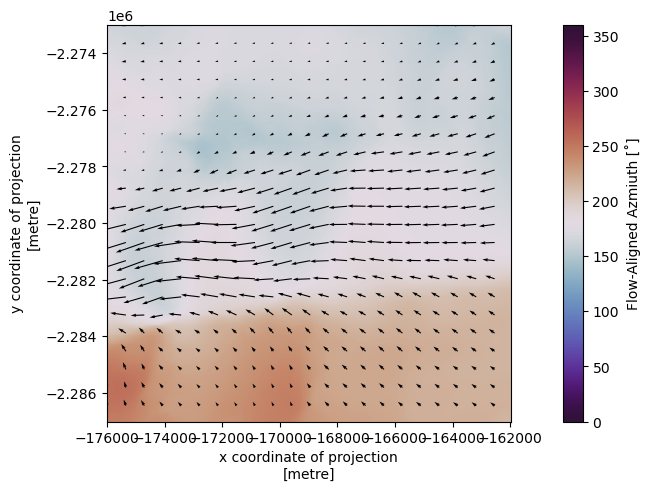

In [10]:

plt.close()
fig, ax = plt.subplots(layout='constrained')
azimuth.plot(cmap='twilight_shifted', vmin=0, vmax=360, cbar_kwargs={'label': 'Flow-Aligned Azmiuth [˚]'})

# Plot the velocity as a quiver plot
show_every = 20
skip = slice(None, None, show_every)
ax.quiver(vx.squeeze().x.values[skip], vx.squeeze().y.values[skip], vx.squeeze().values[skip, skip], vy.squeeze().values[skip, skip])#, , )

ax.set_title(None)


We can now run the `pdemtools` hillshade function, but instead of inputting a single value to our `hillshade_azimuth` variable, we feed in our calculated azimuths as a `numpy` array (by calling `.values` on the xarray DataArray). Note the relatively high `hillshade_z_factor`!

In [11]:

fa_hillshade = dem.pdt.terrain(
    'hillshade', 
    hillshade_z_factor=10, 
    hillshade_azimuth = azimuth.values,
    hillshade_multidirectional=False,
)


Here's the final result!

Text(0.5, 1.0, 'Flow-aware hillshade (MacGregor et al.)')

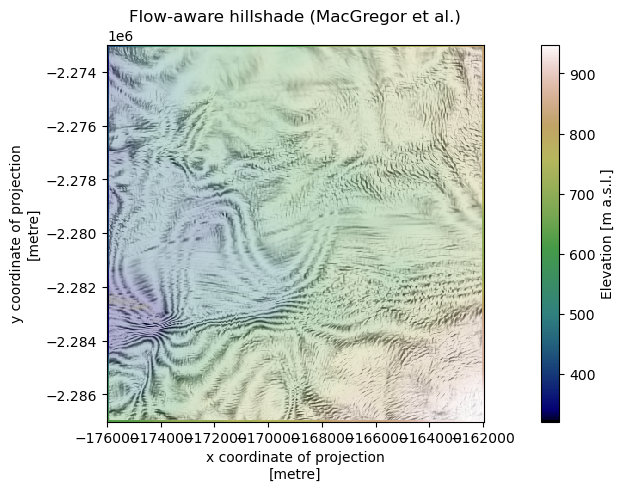

In [12]:

plt.close()
fig, ax = plt.subplots(layout='constrained')

dem.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Elevation [m a.s.l.]'})
# vv.plot(cmap='viridis', ax=ax, cbar_kwargs={'label': 'Velocity [m/a]'})
fa_hillshade.plot(ax=ax, cmap='Greys_r', alpha=0.7, add_colorbar=False)

ax.set_aspect('equal')
ax.set_title('Flow-aware hillshade (MacGregor et al.)')


## Compare with BedMachine

Because Jakobshavn has relatively well-constrained observations of basal topography, one check we could do is to compare with BedMachine:

In [13]:

bedmachine_fpath = "/Users/tom/Library/CloudStorage/OneDrive-DurhamUniversity/data/bedmachine_5/BedMachineGreenland-v5.nc"

bed = rxr.open_rasterio(f"{bedmachine_fpath}")["bed"]
bed = bed.rio.reproject_match(dem, Resampling.bilinear)

bed_hillshade =  bed.pdt.terrain('hillshade', hillshade_z_factor=2, hillshade_multidirectional=True)


For visiblity purposes, I have scaled the colour bar for the region outside of the valley:

Text(0.5, 1.0, 'BedMachine hillshade')

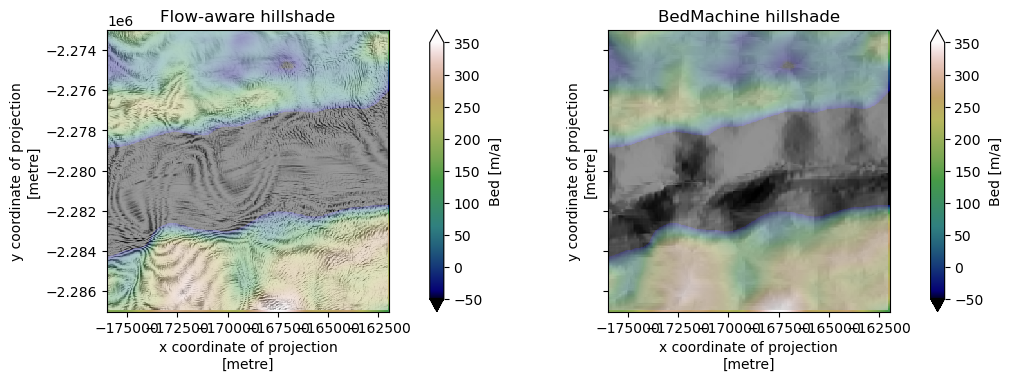

In [14]:

plt.close()
fig, axes = plt.subplots(layout='constrained', ncols=2, figsize=(10,3.7), sharex=True, sharey=True)

ax = axes[0]
bed.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Bed [m/a]'}, vmin=-50, vmax=350)  # vmin=-1500, vmax=-500)
fa_hillshade.plot(ax=ax, cmap='Greys_r', alpha=0.6, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('Flow-aware hillshade')

ax = axes[1]
bed.plot(cmap='gist_earth', ax=ax, cbar_kwargs={'label': 'Bed [m/a]'}, vmin=-50, vmax=350)  # vmin=-1500, vmax=-500)
bed_hillshade.plot(ax=ax, cmap='Greys_r', alpha=0.6, add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('BedMachine hillshade')


We can indeed see reflections of the basal topography in the flow-aligned hillshade!